# Given by the template 
https://colab.research.google.com/drive/1495rzqiMxfqwqBjaanDwDGN7eOS4oXRX 


**Install requirements**

In [0]:
# !pip3 install 'torch==1.3.1'
# !pip3 install 'torchvision==0.5.0'
# !pip3 install 'Pillow-SIMD'
# !pip3 install 'tqdm'

**Import libraries**

In [0]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm

**Set Arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 102 # 101 + 1: There is an extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

**Define Data Preprocessing**

In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
])

**Prepare Dataset**

In [0]:
# Clone github repository with data
if not os.path.isdir('./Caltech101'):
#   !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git
    !git clone https://github.com/Barrel-Titor/Homework2-Caltech101.git
    !mv 'Homework2-Caltech101' 'Caltech101'

DATA_DIR = 'Caltech101/101_ObjectCategories'

In [0]:
from Caltech101.caltech_dataset import Caltech

# Prepare Pytorch train/test Datasets
train_val_dataset = Caltech(DATA_DIR, split='train',  transform=train_transform)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)

train_indexes = list(range(0, len(train_val_dataset), 2))   # split the indices for your train split
val_indexes = list(range(1, len(train_val_dataset), 2))     # split the indices for your val split

train_dataset = Subset(train_val_dataset, train_indexes)
val_dataset = Subset(train_val_dataset, val_indexes)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

Train Dataset: 2892
Valid Dataset: 2892
Test Dataset: 2893


**Prepare Dataloaders**

In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

**Prepare Network**

In [0]:
net = alexnet() # Loading AlexNet model

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

In [0]:
net

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

**Prepare Training**

In [0]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Train and Validation**

| Current hyperparameters | Value |
| --- | --- |
| Initial learning rate | 0.001 |
| Decaying policy | StepLR |
| Decaying step size | 20 epochs |
| Decaying factor | 0.1 |
| Optimiser | SGD |
| Epochs | 30 |



In [0]:
from copy import deepcopy

loss_hist = []
acc_hist = []

# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
cudnn.benchmark     # Calling this optimizes runtime

current_step = 0

In [0]:
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

    # Train part
    net.train() # Sets module in training mode

    # Iterate over the dataset
    for images, labels in train_dataloader:
        # Bring data over the device of choice
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # PyTorch, by default, accumulates gradients after each backward pass
        # We need to manually set the gradients to zero before starting a new iteration
        optimizer.zero_grad() # Zero-ing the gradients

        # Forward pass to the network
        outputs = net(images)

        # Compute loss based on output and ground truth
        loss = criterion(outputs, labels)

        # Log loss
        if current_step % LOG_FREQUENCY == 0:
            print('Step {}, Loss {}'.format(current_step, loss.item()))

        # Compute gradients for each layer and update weights
        loss.backward()  # backward pass: computes gradients
        optimizer.step() # update weights based on accumulated gradients

        current_step += 1

    # Step the scheduler
    scheduler.step() 

    # Use the best model for validation
    if not loss_hist or loss.item() < min(loss_hist):
        best_net = deepcopy(net)

    # Record loss after each epoch

    # Validation part
    best_net.train(False) # Set Network to evaluation mode

    running_corrects = 0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Forward Pass
            outputs = best_net(images)

            # Get predictions
            _, preds = torch.max(outputs.data, 1)
            
            # Update Corrects
            running_corrects += torch.sum(preds == labels.data).data.item()

    # Calculate Accuracy
    accuracy = running_corrects / float(len(val_dataset))
    print('Accuracy {}\n'.format(accuracy))

    # Record loss and accuracy after each epoch
    loss_hist.append(loss.item())
    acc_hist.append(accuracy)

Starting epoch 1/30, LR = [0.001]
Step 0, Loss 4.514472484588623
Step 10, Loss 4.51784086227417
Accuracy 0.09197786998616875

Starting epoch 2/30, LR = [0.001]
Step 20, Loss 4.451831817626953
Accuracy 0.09197786998616875

Starting epoch 3/30, LR = [0.001]
Step 30, Loss 4.3598456382751465
Accuracy 0.09197786998616875

Starting epoch 4/30, LR = [0.001]
Step 40, Loss 4.310239315032959
Accuracy 0.09197786998616875

Starting epoch 5/30, LR = [0.001]
Step 50, Loss 4.355845928192139
Accuracy 0.09301521438450899

Starting epoch 6/30, LR = [0.001]
Step 60, Loss 4.299665927886963
Accuracy 0.09612724757952974

Starting epoch 7/30, LR = [0.001]
Step 70, Loss 4.188819885253906
Accuracy 0.09439834024896265

Starting epoch 8/30, LR = [0.001]
Step 80, Loss 4.319115161895752
Accuracy 0.09647302904564316

Starting epoch 9/30, LR = [0.001]
Step 90, Loss 4.173344612121582
Accuracy 0.09716459197786999

Starting epoch 10/30, LR = [0.001]
Step 100, Loss 4.158774375915527
Accuracy 0.09336099585062241

Startin

In [0]:
import matplotlib.pyplot as plt

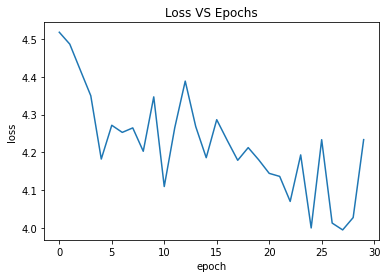

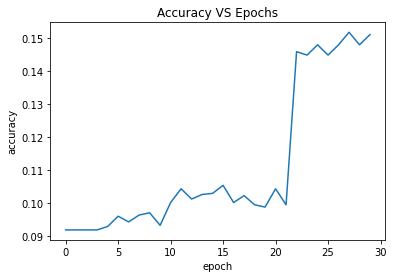

In [0]:
plt.plot(loss_hist)
plt.title('Loss VS Epochs')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

plt.plot(acc_hist)
plt.title('Accuracy VS Epochs')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

**Test**

In [0]:
best_net = best_net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
best_net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = best_net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 12/12 [00:12<00:00,  1.01s/it]

Test Accuracy: 0.15485655029381265


# Experiment with different sets of hyperparameters

### Hyperparameter set 1

| Current hyperparameters | Value |
| --- | --- |
| Initial learning rate | 0.1 |
| Decaying policy | StepLR |
| Decaying step size | 20 epochs |
| Decaying factor | 0.1 |
| Optimiser | SGD |
| Epochs | 30 |

In [0]:
LR = 1e-1            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

**Prepare Network**

In [0]:
net = alexnet() # Loading AlexNet model

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

**Prepare Training**

In [0]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [0]:
from copy import deepcopy

loss_hist = []
acc_hist = []

# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
cudnn.benchmark     # Calling this optimizes runtime

current_step = 0

In [0]:
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

    # Train part
    net.train() # Sets module in training mode

    # Iterate over the dataset
    for images, labels in train_dataloader:
        # Bring data over the device of choice
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # PyTorch, by default, accumulates gradients after each backward pass
        # We need to manually set the gradients to zero before starting a new iteration
        optimizer.zero_grad() # Zero-ing the gradients

        # Forward pass to the network
        outputs = net(images)

        # Compute loss based on output and ground truth
        loss = criterion(outputs, labels)

        # Log loss
        if current_step % LOG_FREQUENCY == 0:
            print('Step {}, Loss {}'.format(current_step, loss.item()))

        # Compute gradients for each layer and update weights
        loss.backward()  # backward pass: computes gradients
        # torch.nn.utils.clip_grad_norm_(parameters_to_optimize, 0.5) # prevent gradient explosion
        optimizer.step() # update weights based on accumulated gradients

        current_step += 1

    # Step the scheduler
    scheduler.step() 

    # Use the best model for validation
    if not loss_hist or loss.item() < min(loss_hist):
        best_net = deepcopy(net)

    # Record loss after each epoch

    # Validation part
    best_net.train(False) # Set Network to evaluation mode

    running_corrects = 0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Forward Pass
            outputs = best_net(images)

            # Get predictions
            _, preds = torch.max(outputs.data, 1)
            
            # Update Corrects
            running_corrects += torch.sum(preds == labels.data).data.item()

    # Calculate Accuracy
    accuracy = running_corrects / float(len(val_dataset))
    print('Accuracy {}\n'.format(accuracy))

    # Record loss and accuracy after each epoch
    loss_hist.append(loss.item())
    acc_hist.append(accuracy)

Starting epoch 1/30, LR = [0.1]
Step 0, Loss 4.624452590942383
Step 10, Loss 4.465866565704346
Accuracy 0.09197786998616875

Starting epoch 2/30, LR = [0.1]
Step 20, Loss 4.425328254699707
Accuracy 0.09232365145228216

Starting epoch 3/30, LR = [0.1]
Step 30, Loss 4.268335819244385
Accuracy 0.09197786998616875

Starting epoch 4/30, LR = [0.1]
Step 40, Loss 4.085280418395996
Accuracy 0.09232365145228216

Starting epoch 5/30, LR = [0.1]
Step 50, Loss 4.136882305145264
Accuracy 0.09232365145228216

Starting epoch 6/30, LR = [0.1]
Step 60, Loss 4.123317241668701
Accuracy 0.09232365145228216

Starting epoch 7/30, LR = [0.1]
Step 70, Loss 4.169169902801514
Accuracy 0.16701244813278007

Starting epoch 8/30, LR = [0.1]
Step 80, Loss 3.807194471359253
Accuracy 0.16701244813278007

Starting epoch 9/30, LR = [0.1]
Step 90, Loss 3.985321521759033
Accuracy 0.16701244813278007

Starting epoch 10/30, LR = [0.1]
Step 100, Loss 4.368847370147705
Accuracy 0.16701244813278007

Starting epoch 11/30, LR = 

In [0]:
import matplotlib.pyplot as plt

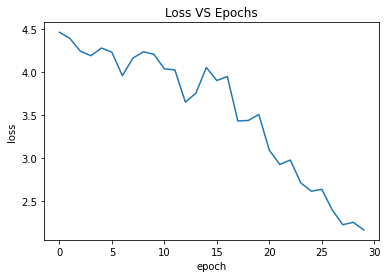

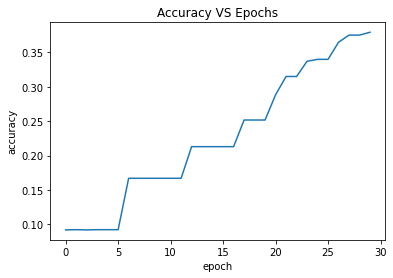

In [0]:
plt.plot(loss_hist)
plt.title('Loss VS Epochs')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

plt.plot(acc_hist)
plt.title('Accuracy VS Epochs')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

**Test**

In [0]:
best_net = best_net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
best_net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = best_net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 12/12 [00:11<00:00,  1.07it/s]

Test Accuracy: 0.39094365710335294


## Hyperparameter set 2

| Current hyperparameters | Value |
| --- | --- |
| Initial learning rate | 0.1 |
| Decaying policy | StepLR |
| Decaying step size | 10 epochs |
| Decaying factor | 0.3 |
| Optimiser | SGD |
| Epochs | 30 |

In [0]:
LR = 0.1             # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 10       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.3          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

**Prepare Network**

In [0]:
net = alexnet() # Loading AlexNet model

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

**Prepare Training**

In [0]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [0]:
from copy import deepcopy

loss_hist = []
acc_hist = []

# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
cudnn.benchmark     # Calling this optimizes runtime

current_step = 0

In [0]:
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
    print('Starting epoch {}/{}, LR = {}'.format(
        epoch+1, NUM_EPOCHS, optimizer.param_groups[0]['lr']))

    # Train part
    net.train() # Sets module in training mode

    # Iterate over the dataset
    for images, labels in train_dataloader:
        # Bring data over the device of choice
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # PyTorch, by default, accumulates gradients after each backward pass
        # We need to manually set the gradients to zero before starting a new iteration
        optimizer.zero_grad() # Zero-ing the gradients

        # Forward pass to the network
        outputs = net(images)

        # Compute loss based on output and ground truth
        loss = criterion(outputs, labels)

        # Log loss
        if current_step % LOG_FREQUENCY == 0:
            print('Step {}, Loss {}'.format(current_step, loss.item()))

        # Compute gradients for each layer and update weights
        loss.backward()  # backward pass: computes gradients
        optimizer.step() # update weights based on accumulated gradients

        current_step += 1

    # Step the scheduler
    scheduler.step() 

    # Use the best model for validation
    if not loss_hist or loss.item() < min(loss_hist):
        best_net = deepcopy(net)

    # Record loss after each epoch

    # Validation part
    best_net.train(False) # Set Network to evaluation mode

    running_corrects = 0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Forward Pass
            outputs = best_net(images)

            # Get predictions
            _, preds = torch.max(outputs.data, 1)
            
            # Update Corrects
            running_corrects += torch.sum(preds == labels.data).data.item()

    # Calculate Accuracy
    accuracy = running_corrects / float(len(val_dataset))
    print('Accuracy {}\n'.format(accuracy))

    # Record loss and accuracy after each epoch
    loss_hist.append(loss.item())
    acc_hist.append(accuracy)

Starting epoch 1/30, LR = 0.1
Step 0, Loss 4.626758098602295
Step 10, Loss 4.489613056182861
Accuracy 0.09197786998616875

Starting epoch 2/30, LR = 0.1
Step 20, Loss 4.47728157043457
Accuracy 0.09232365145228216

Starting epoch 3/30, LR = 0.1
Step 30, Loss 4.366040229797363
Accuracy 0.09232365145228216

Starting epoch 4/30, LR = 0.1
Step 40, Loss 4.136793613433838
Accuracy 0.09232365145228216

Starting epoch 5/30, LR = 0.1
Step 50, Loss 4.1496782302856445
Accuracy 0.09232365145228216

Starting epoch 6/30, LR = 0.1
Step 60, Loss 3.923895835876465
Accuracy 0.17946058091286307

Starting epoch 7/30, LR = 0.1
Step 70, Loss 4.11142635345459
Accuracy 0.17946058091286307

Starting epoch 8/30, LR = 0.1
Step 80, Loss 4.246984004974365
Accuracy 0.17946058091286307

Starting epoch 9/30, LR = 0.1
Step 90, Loss 4.18563175201416
Accuracy 0.17946058091286307

Starting epoch 10/30, LR = 0.1
Step 100, Loss 4.118852138519287
Accuracy 0.17946058091286307

Starting epoch 11/30, LR = 0.03
Step 110, Loss 4.

In [0]:
import matplotlib.pyplot as plt

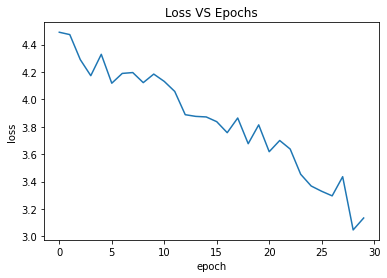

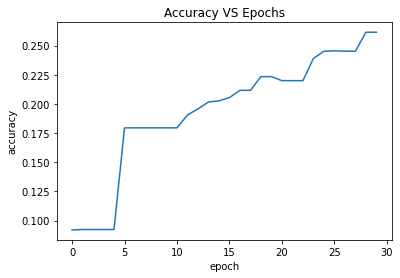

In [0]:
plt.plot(loss_hist)
plt.title('Loss VS Epochs')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

plt.plot(acc_hist)
plt.title('Accuracy VS Epochs')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

**Test**

In [0]:
best_net = best_net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
best_net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = best_net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 12/12 [00:11<00:00,  1.05it/s]

Test Accuracy: 0.27134462495679224


# Transfer learning and Data Augmentation

**Set Arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 102 # 101 + 1: There is an extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LOG_FREQUENCY = 10

**Define Data Preprocessing**

In [0]:
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.RandomCrop(224),  # Data Augmentation
                                      transforms.RandomHorizontalFlip(),    # Data Augmentation
                                      transforms.ColorJitter(),    # Data Augmentation
                                      transforms.ToTensor(),       # Turn PIL Image to torch.Tensor
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalizes with mean and standard deviation of ImageNet
])

eval_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(),       # Turn PIL Image to torch.Tensor
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalizes with mean and standard deviation of ImageNet
])

**Prepare Dataset**

In [3]:
# Clone github repository with data
if not os.path.isdir('./Caltech101'):
#   !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git
    !git clone https://github.com/Barrel-Titor/Homework2-Caltech101.git
    !mv 'Homework2-Caltech101' 'Caltech101'

DATA_DIR = 'Caltech101/101_ObjectCategories'

Cloning into 'Homework2-Caltech101'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9265 (delta 4), reused 7 (delta 2), pack-reused 9256
Receiving objects: 100% (9265/9265), 129.48 MiB | 28.36 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Checking out files: 100% (9149/9149), done.


In [4]:
from Caltech101.caltech_dataset import Caltech

# Prepare Pytorch train/test Datasets
train_val_dataset = Caltech(DATA_DIR, split='train',  transform=train_transform)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)

train_indexes = list(range(0, len(train_val_dataset), 2))   # split the indices for your train split
val_indexes = list(range(1, len(train_val_dataset), 2))     # split the indices for your val split

train_dataset = Subset(train_val_dataset, train_indexes)
val_dataset = Subset(train_val_dataset, val_indexes)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

Train Dataset: 2892
Valid Dataset: 2892
Test Dataset: 2893


**Prepare Dataloaders**

In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

### Hyperparameter set 1

| Current hyperparameters | Value |
| --- | --- |
| Initial learning rate | 0.001 |
| Decaying policy | StepLR |
| Decaying step size | 10 epochs |
| Decaying factor | 0.1 |
| Optimiser | SGD |
| Epochs | 30 |



**Set Arguments**

In [0]:
LR = 1e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 10       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

**Prepare Network**

In [0]:
# Loading AlexNet model
net = alexnet(pretrained=True) 

In [0]:
# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

In [0]:
net

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

**Prepare Training**

In [0]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Train and Validation**

In [0]:
from copy import deepcopy

loss_hist = []
acc_hist = []

# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
cudnn.benchmark     # Calling this optimizes runtime

current_step = 0

In [0]:
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

    # Train part
    net.train() # Sets module in training mode

    # Iterate over the dataset
    for images, labels in train_dataloader:
        # Bring data over the device of choice
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # PyTorch, by default, accumulates gradients after each backward pass
        # We need to manually set the gradients to zero before starting a new iteration
        optimizer.zero_grad() # Zero-ing the gradients

        # Forward pass to the network
        outputs = net(images)

        # Compute loss based on output and ground truth
        loss = criterion(outputs, labels)

        # Log loss
        if current_step % LOG_FREQUENCY == 0:
            print('Step {}, Loss {}'.format(current_step, loss.item()))

        # Compute gradients for each layer and update weights
        loss.backward()  # backward pass: computes gradients
        optimizer.step() # update weights based on accumulated gradients

        current_step += 1

    # Step the scheduler
    scheduler.step() 

    # Use the best model for validation
    if not loss_hist or loss.item() < min(loss_hist):
        best_net = deepcopy(net)

    # Record loss after each epoch

    # Validation part
    best_net.train(False) # Set Network to evaluation mode

    running_corrects = 0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Forward Pass
            outputs = best_net(images)

            # Get predictions
            _, preds = torch.max(outputs.data, 1)
            
            # Update Corrects
            running_corrects += torch.sum(preds == labels.data).data.item()

    # Calculate Accuracy
    accuracy = running_corrects / float(len(val_dataset))
    print('Accuracy {}\n'.format(accuracy))

    # Record loss and accuracy after each epoch
    loss_hist.append(loss.item())
    acc_hist.append(accuracy)

Starting epoch 1/30, LR = [0.001]
Step 0, Loss 4.983925819396973
Step 10, Loss 3.253845691680908
Accuracy 0.2869986168741355

Starting epoch 2/30, LR = [0.001]
Step 20, Loss 2.838451862335205
Accuracy 0.4512448132780083

Starting epoch 3/30, LR = [0.001]
Step 30, Loss 2.124786615371704
Accuracy 0.5622406639004149

Starting epoch 4/30, LR = [0.001]
Step 40, Loss 1.4385613203048706
Accuracy 0.6614799446749654

Starting epoch 5/30, LR = [0.001]
Step 50, Loss 0.9223219752311707
Accuracy 0.7444674965421854

Starting epoch 6/30, LR = [0.001]
Step 60, Loss 0.7460620999336243
Accuracy 0.7690179806362379

Starting epoch 7/30, LR = [0.001]
Step 70, Loss 0.5016437768936157
Accuracy 0.7852697095435685

Starting epoch 8/30, LR = [0.001]
Step 80, Loss 0.573759138584137
Accuracy 0.8046334716459198

Starting epoch 9/30, LR = [0.001]
Step 90, Loss 0.39922985434532166
Accuracy 0.8084370677731674

Starting epoch 10/30, LR = [0.001]
Step 100, Loss 0.355316162109375
Accuracy 0.8029045643153527

Starting ep

In [0]:
import matplotlib.pyplot as plt

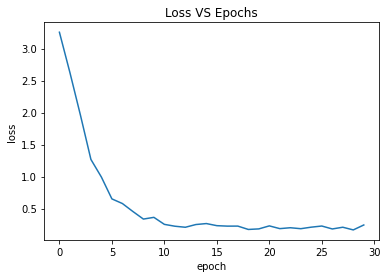

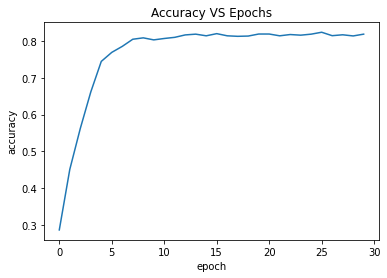

In [0]:
plt.plot(loss_hist)
plt.title('Loss VS Epochs')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

plt.plot(acc_hist)
plt.title('Accuracy VS Epochs')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

**Test**

In [0]:
best_net = best_net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
best_net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = best_net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 12/12 [00:13<00:00,  1.08s/it]

Test Accuracy: 0.8212927756653993


## Hyperparameter set 2

| Current hyperparameters | Value |
| --- | --- |
| Initial learning rate | 0.001 |
| Decaying policy | StepLR |
| Decaying step size | 5 epochs |
| Decaying factor | 0.1 |
| Optimiser | SGD |
| Epochs | 30 |



**Set Arguments**

In [0]:
LR = 1e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 5        # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

**Prepare Network**

In [0]:
# Loading AlexNet model
net = alexnet(pretrained=True) 

In [0]:
# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

**Prepare Training**

In [0]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Train and Validation**

In [0]:
from copy import deepcopy

loss_hist = []
acc_hist = []

# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
cudnn.benchmark     # Calling this optimizes runtime

current_step = 0

In [0]:
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

    # Train part
    net.train() # Sets module in training mode

    # Iterate over the dataset
    for images, labels in train_dataloader:
        # Bring data over the device of choice
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # PyTorch, by default, accumulates gradients after each backward pass
        # We need to manually set the gradients to zero before starting a new iteration
        optimizer.zero_grad() # Zero-ing the gradients

        # Forward pass to the network
        outputs = net(images)

        # Compute loss based on output and ground truth
        loss = criterion(outputs, labels)

        # Log loss
        if current_step % LOG_FREQUENCY == 0:
            print('Step {}, Loss {}'.format(current_step, loss.item()))

        # Compute gradients for each layer and update weights
        loss.backward()  # backward pass: computes gradients
        optimizer.step() # update weights based on accumulated gradients

        current_step += 1

    # Step the scheduler
    scheduler.step() 

    # Use the best model for validation
    if not loss_hist or loss.item() < min(loss_hist):
        best_net = deepcopy(net)

    # Record loss after each epoch

    # Validation part
    best_net.train(False) # Set Network to evaluation mode

    running_corrects = 0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Forward Pass
            outputs = best_net(images)

            # Get predictions
            _, preds = torch.max(outputs.data, 1)
            
            # Update Corrects
            running_corrects += torch.sum(preds == labels.data).data.item()

    # Calculate Accuracy
    accuracy = running_corrects / float(len(val_dataset))
    print('Accuracy {}\n'.format(accuracy))

    # Record loss and accuracy after each epoch
    loss_hist.append(loss.item())
    acc_hist.append(accuracy)

Starting epoch 1/30, LR = [0.001]
Step 0, Loss 4.836269378662109
Step 10, Loss 3.4196667671203613
Accuracy 0.2821576763485477

Starting epoch 2/30, LR = [0.001]
Step 20, Loss 2.642625093460083
Accuracy 0.45470262793914246

Starting epoch 3/30, LR = [0.001]
Step 30, Loss 1.9410220384597778
Accuracy 0.5743430152143845

Starting epoch 4/30, LR = [0.001]
Step 40, Loss 1.4295628070831299
Accuracy 0.6822268326417704

Starting epoch 5/30, LR = [0.001]
Step 50, Loss 0.9842467904090881
Accuracy 0.73582295988935

Starting epoch 6/30, LR = [0.0001]
Step 60, Loss 0.82724928855896
Accuracy 0.7385892116182573

Starting epoch 7/30, LR = [0.0001]
Step 70, Loss 0.7325082421302795
Accuracy 0.7455048409405256

Starting epoch 8/30, LR = [0.0001]
Step 80, Loss 0.8222002983093262
Accuracy 0.7510373443983402

Starting epoch 9/30, LR = [0.0001]
Step 90, Loss 0.6232385635375977
Accuracy 0.7468879668049793

Starting epoch 10/30, LR = [0.0001]
Step 100, Loss 0.6196423768997192
Accuracy 0.7603734439834025

Starti

In [0]:
import matplotlib.pyplot as plt

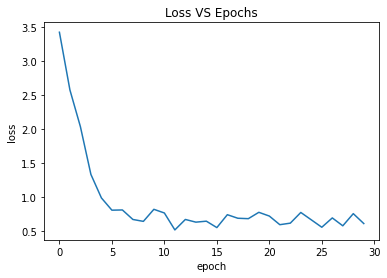

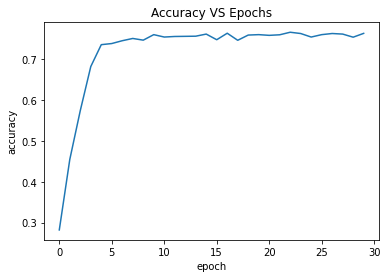

In [0]:
plt.plot(loss_hist)
plt.title('Loss VS Epochs')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

plt.plot(acc_hist)
plt.title('Accuracy VS Epochs')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

**Test**

In [0]:
best_net = best_net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
best_net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = best_net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 12/12 [00:12<00:00,  1.08s/it]

Test Accuracy: 0.7684064984445212


## Hyperparameter set 3 (Best performed)

| Current hyperparameters | Value |
| --- | --- |
| Initial learning rate | 0.001 |
| Decaying policy | ReduceLROnPlateau |
| Decaying factor | 0.1 |
| Decaying patience | 3 epochs |
| Optimiser | SGD |
| Epochs | 30 |



**Set Arguments**

In [0]:
LR = 1e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
FACTOR = 0.1         # How many epochs before decreasing learning rate (if using a step-down policy)
PATIENCE = 3         # Multiplicative factor for learning rate step-down

**Prepare Network**

In [0]:
# Loading AlexNet model
net = alexnet(pretrained=True) 

In [0]:
# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

**Prepare Training**

In [0]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=FACTOR, patience=PATIENCE)

**Train and Validation**

In [0]:
from copy import deepcopy

loss_hist = []
acc_hist = []

# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
cudnn.benchmark     # Calling this optimizes runtime

current_step = 0

In [0]:
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, optimizer.param_groups[0]['lr']))

    # Train part
    net.train() # Sets module in training mode

    # Iterate over the dataset
    for images, labels in train_dataloader:
        # Bring data over the device of choice
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # PyTorch, by default, accumulates gradients after each backward pass
        # We need to manually set the gradients to zero before starting a new iteration
        optimizer.zero_grad() # Zero-ing the gradients

        # Forward pass to the network
        outputs = net(images)

        # Compute loss based on output and ground truth
        loss = criterion(outputs, labels)

        # Log loss
        if current_step % LOG_FREQUENCY == 0:
            print('Step {}, Loss {}'.format(current_step, loss.item()))

        # Compute gradients for each layer and update weights
        loss.backward()  # backward pass: computes gradients
        optimizer.step() # update weights based on accumulated gradients

        current_step += 1

    # Step the scheduler
    scheduler.step(loss) 

    # Use the best model for validation
    if not loss_hist or loss.item() < min(loss_hist):
        best_net = deepcopy(net)

    # Record loss after each epoch

    # Validation part
    best_net.train(False) # Set Network to evaluation mode

    running_corrects = 0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Forward Pass
            outputs = best_net(images)

            # Get predictions
            _, preds = torch.max(outputs.data, 1)
            
            # Update Corrects
            running_corrects += torch.sum(preds == labels.data).data.item()

    # Calculate Accuracy
    accuracy = running_corrects / float(len(val_dataset))
    print('Accuracy {}\n'.format(accuracy))

    # Record loss and accuracy after each epoch
    loss_hist.append(loss.item())
    acc_hist.append(accuracy)

Starting epoch 1/30, LR = 0.001
Step 0, Loss 4.855043411254883
Step 10, Loss 3.407418966293335
Accuracy 0.2766251728907331

Starting epoch 2/30, LR = 0.001
Step 20, Loss 2.550562620162964
Accuracy 0.45850622406639

Starting epoch 3/30, LR = 0.001
Step 30, Loss 2.078125
Accuracy 0.5542876901798064

Starting epoch 4/30, LR = 0.001
Step 40, Loss 1.4422149658203125
Accuracy 0.6587136929460581

Starting epoch 5/30, LR = 0.001
Step 50, Loss 0.9714542031288147
Accuracy 0.729253112033195

Starting epoch 6/30, LR = 0.001
Step 60, Loss 0.7547634243965149
Accuracy 0.7690179806362379

Starting epoch 7/30, LR = 0.001
Step 70, Loss 0.49930885434150696
Accuracy 0.7766251728907331

Starting epoch 8/30, LR = 0.001
Step 80, Loss 0.5107560157775879
Accuracy 0.7911479944674965

Starting epoch 9/30, LR = 0.001
Step 90, Loss 0.3915749192237854
Accuracy 0.7980636237897649

Starting epoch 10/30, LR = 0.001
Step 100, Loss 0.37049412727355957
Accuracy 0.7939142461964038

Starting epoch 11/30, LR = 0.001
Step 11

In [0]:
import matplotlib.pyplot as plt

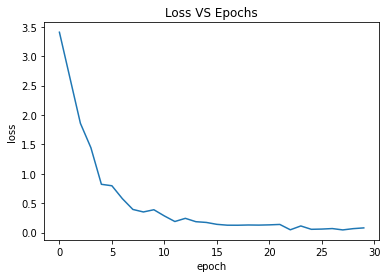

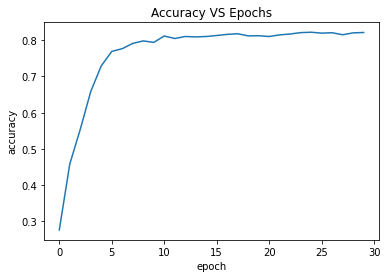

In [0]:
plt.plot(loss_hist)
plt.title('Loss VS Epochs')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

plt.plot(acc_hist)
plt.title('Accuracy VS Epochs')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

**Test**

In [0]:
best_net = best_net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
best_net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = best_net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 12/12 [00:13<00:00,  1.11s/it]

Test Accuracy: 0.832353957829243


### Train only the FC layers

**Prepare Network**

In [9]:
# Loading AlexNet model
net = alexnet(pretrained=True) 

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth


In [0]:
# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

**Prepare Training**

In [0]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.classifier.parameters() # Train only the FC layers

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=FACTOR, patience=PATIENCE)

**Train and Validation**

In [0]:
from copy import deepcopy

loss_hist = []
acc_hist = []

# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
cudnn.benchmark     # Calling this optimizes runtime

current_step = 0

In [15]:
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, optimizer.param_groups[0]['lr']))

    # Train part
    net.train() # Sets module in training mode

    # Iterate over the dataset
    for images, labels in train_dataloader:
        # Bring data over the device of choice
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # PyTorch, by default, accumulates gradients after each backward pass
        # We need to manually set the gradients to zero before starting a new iteration
        optimizer.zero_grad() # Zero-ing the gradients

        # Forward pass to the network
        outputs = net(images)

        # Compute loss based on output and ground truth
        loss = criterion(outputs, labels)

        # Log loss
        if current_step % LOG_FREQUENCY == 0:
            print('Step {}, Loss {}'.format(current_step, loss.item()))

        # Compute gradients for each layer and update weights
        loss.backward()  # backward pass: computes gradients
        optimizer.step() # update weights based on accumulated gradients

        current_step += 1

    # Step the scheduler
    scheduler.step(loss) 

    # Use the best model for validation
    if not loss_hist or loss.item() < min(loss_hist):
        best_net = deepcopy(net)

    # Record loss after each epoch

    # Validation part
    best_net.train(False) # Set Network to evaluation mode

    running_corrects = 0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Forward Pass
            outputs = best_net(images)

            # Get predictions
            _, preds = torch.max(outputs.data, 1)
            
            # Update Corrects
            running_corrects += torch.sum(preds == labels.data).data.item()

    # Calculate Accuracy
    accuracy = running_corrects / float(len(val_dataset))
    print('Accuracy {}\n'.format(accuracy))

    # Record loss and accuracy after each epoch
    loss_hist.append(loss.item())
    acc_hist.append(accuracy)

Starting epoch 1/30, LR = 0.001
Step 0, Loss 4.971323490142822
Step 10, Loss 3.460832118988037
Accuracy 0.27074688796680496

Starting epoch 2/30, LR = 0.001
Step 20, Loss 2.492248296737671
Accuracy 0.4581604426002766

Starting epoch 3/30, LR = 0.001
Step 30, Loss 1.8541783094406128
Accuracy 0.5912863070539419

Starting epoch 4/30, LR = 0.001
Step 40, Loss 1.7809301614761353
Accuracy 0.6590594744121715

Starting epoch 5/30, LR = 0.001
Step 50, Loss 1.4489717483520508
Accuracy 0.7036652835408023

Starting epoch 6/30, LR = 0.001
Step 60, Loss 1.1981910467147827
Accuracy 0.7375518672199171

Starting epoch 7/30, LR = 0.001
Step 70, Loss 1.0466983318328857
Accuracy 0.7614107883817427

Starting epoch 8/30, LR = 0.001
Step 80, Loss 0.8690292239189148
Accuracy 0.7603734439834025

Starting epoch 9/30, LR = 0.001
Step 90, Loss 0.828432023525238
Accuracy 0.7883817427385892

Starting epoch 10/30, LR = 0.001
Step 100, Loss 0.6528757214546204
Accuracy 0.8032503457814661

Starting epoch 11/30, LR = 0.

In [0]:
import matplotlib.pyplot as plt

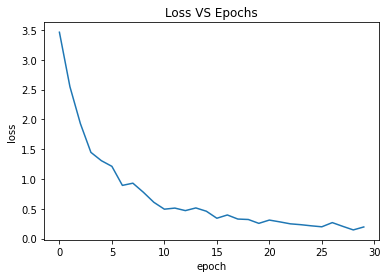

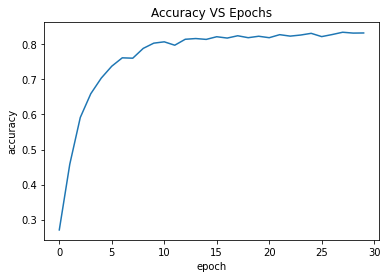

In [17]:
plt.plot(loss_hist)
plt.title('Loss VS Epochs')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

plt.plot(acc_hist)
plt.title('Accuracy VS Epochs')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

**Test**

In [18]:
best_net = best_net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
best_net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = best_net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 12/12 [00:12<00:00,  1.03s/it]

Test Accuracy: 0.8354649153128241


### Train only the Conv layers

**Prepare Network**

In [0]:
# Loading AlexNet model
net = alexnet(pretrained=True) 

In [0]:
# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

**Prepare Training**

In [0]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.features.parameters() # Train only the Conv layers

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=FACTOR, patience=PATIENCE)

**Train and Validation**

In [0]:
from copy import deepcopy

loss_hist = []
acc_hist = []

# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
cudnn.benchmark     # Calling this optimizes runtime

current_step = 0

In [23]:
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, optimizer.param_groups[0]['lr']))

    # Train part
    net.train() # Sets module in training mode

    # Iterate over the dataset
    for images, labels in train_dataloader:
        # Bring data over the device of choice
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # PyTorch, by default, accumulates gradients after each backward pass
        # We need to manually set the gradients to zero before starting a new iteration
        optimizer.zero_grad() # Zero-ing the gradients

        # Forward pass to the network
        outputs = net(images)

        # Compute loss based on output and ground truth
        loss = criterion(outputs, labels)

        # Log loss
        if current_step % LOG_FREQUENCY == 0:
            print('Step {}, Loss {}'.format(current_step, loss.item()))

        # Compute gradients for each layer and update weights
        loss.backward()  # backward pass: computes gradients
        optimizer.step() # update weights based on accumulated gradients

        current_step += 1

    # Step the scheduler
    scheduler.step(loss) 

    # Use the best model for validation
    if not loss_hist or loss.item() < min(loss_hist):
        best_net = deepcopy(net)

    # Record loss after each epoch

    # Validation part
    best_net.train(False) # Set Network to evaluation mode

    running_corrects = 0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Forward Pass
            outputs = best_net(images)

            # Get predictions
            _, preds = torch.max(outputs.data, 1)
            
            # Update Corrects
            running_corrects += torch.sum(preds == labels.data).data.item()

    # Calculate Accuracy
    accuracy = running_corrects / float(len(val_dataset))
    print('Accuracy {}\n'.format(accuracy))

    # Record loss and accuracy after each epoch
    loss_hist.append(loss.item())
    acc_hist.append(accuracy)

Starting epoch 1/30, LR = 0.001
Step 0, Loss 4.892725467681885
Step 10, Loss 4.698026657104492
Accuracy 0.025242047026279392

Starting epoch 2/30, LR = 0.001
Step 20, Loss 4.592747211456299
Accuracy 0.08782849239280774

Starting epoch 3/30, LR = 0.001
Step 30, Loss 4.462285041809082
Accuracy 0.15767634854771784

Starting epoch 4/30, LR = 0.001
Step 40, Loss 4.277307033538818
Accuracy 0.1718533886583679

Starting epoch 5/30, LR = 0.001
Step 50, Loss 4.24069881439209
Accuracy 0.19674965421853388

Starting epoch 6/30, LR = 0.001
Step 60, Loss 4.301409721374512
Accuracy 0.19605809128630705

Starting epoch 7/30, LR = 0.001
Step 70, Loss 3.9903430938720703
Accuracy 0.21922544951590595

Starting epoch 8/30, LR = 0.001
Step 80, Loss 3.983015775680542
Accuracy 0.23824343015214383

Starting epoch 9/30, LR = 0.001
Step 90, Loss 3.70906662940979
Accuracy 0.24619640387275243

Starting epoch 10/30, LR = 0.001
Step 100, Loss 3.602170705795288
Accuracy 0.254149377593361

Starting epoch 11/30, LR = 0.0

In [0]:
import matplotlib.pyplot as plt

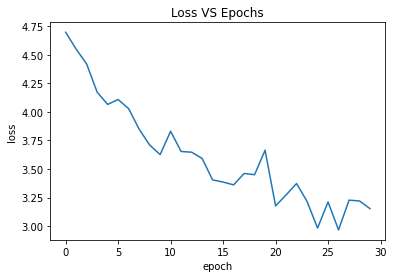

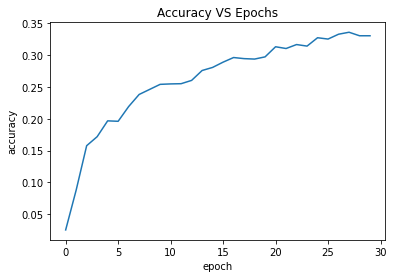

In [25]:
plt.plot(loss_hist)
plt.title('Loss VS Epochs')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

plt.plot(acc_hist)
plt.title('Accuracy VS Epochs')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

**Test**

In [26]:
best_net = best_net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
best_net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = best_net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 12/12 [00:12<00:00,  1.01s/it]

Test Accuracy: 0.3328724507431732


# Use ResNet

**Import libraries**

In [0]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm

**Set Arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 102 # 101 + 1: There is an extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LOG_FREQUENCY = 10

In [0]:
LR = 1e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
FACTOR = 0.1         # How many epochs before decreasing learning rate (if using a step-down policy)
PATIENCE = 3         # Multiplicative factor for learning rate step-down

**Define Data Preprocessing**

In [0]:
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.RandomCrop(224),  # Data Augmentation
                                      transforms.RandomHorizontalFlip(),    # Data Augmentation
                                      transforms.ColorJitter(),    # Data Augmentation
                                      transforms.ToTensor(),       # Turn PIL Image to torch.Tensor
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalizes with mean and standard deviation of ImageNet
])

eval_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(),       # Turn PIL Image to torch.Tensor
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalizes with mean and standard deviation of ImageNet
])

**Prepare Dataset**

In [4]:
# Clone github repository with data
if not os.path.isdir('./Caltech101'):
#   !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git
    !git clone https://github.com/Barrel-Titor/Homework2-Caltech101.git
    !mv 'Homework2-Caltech101' 'Caltech101'

DATA_DIR = 'Caltech101/101_ObjectCategories'

Cloning into 'Homework2-Caltech101'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9265 (delta 4), reused 7 (delta 2), pack-reused 9256
Receiving objects: 100% (9265/9265), 129.48 MiB | 13.75 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Checking out files: 100% (9149/9149), done.


In [5]:
from Caltech101.caltech_dataset import Caltech

# Prepare Pytorch train/test Datasets
train_val_dataset = Caltech(DATA_DIR, split='train',  transform=train_transform)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)

train_indexes = list(range(0, len(train_val_dataset), 2))   # split the indices for your train split
val_indexes = list(range(1, len(train_val_dataset), 2))     # split the indices for your val split

train_dataset = Subset(train_val_dataset, train_indexes)
val_dataset = Subset(train_val_dataset, val_indexes)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

Train Dataset: 2892
Valid Dataset: 2892
Test Dataset: 2893


**Prepare Dataloaders**

In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

**Prepare Network**

In [0]:
from torchvision.models import resnet18

In [8]:
# Loading AlexNet model
net = resnet18(pretrained=True) 

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [0]:
# We need 101 outputs for Caltech-101
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

**Prepare Training**

In [0]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.fc.parameters() # Train only the FC layers

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=FACTOR, patience=PATIENCE)

**Train and Validation**

In [0]:
from copy import deepcopy

loss_hist = []
acc_hist = []

# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
cudnn.benchmark     # Calling this optimizes runtime

current_step = 0

In [14]:
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, optimizer.param_groups[0]['lr']))

    # Train part
    net.train() # Sets module in training mode

    # Iterate over the dataset
    for images, labels in train_dataloader:
        # Bring data over the device of choice
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # PyTorch, by default, accumulates gradients after each backward pass
        # We need to manually set the gradients to zero before starting a new iteration
        optimizer.zero_grad() # Zero-ing the gradients

        # Forward pass to the network
        outputs = net(images)

        # Compute loss based on output and ground truth
        loss = criterion(outputs, labels)

        # Log loss
        if current_step % LOG_FREQUENCY == 0:
            print('Step {}, Loss {}'.format(current_step, loss.item()))

        # Compute gradients for each layer and update weights
        loss.backward()  # backward pass: computes gradients
        optimizer.step() # update weights based on accumulated gradients

        current_step += 1

    # Step the scheduler
    scheduler.step(loss) 

    # Use the best model for validation
    if not loss_hist or loss.item() < min(loss_hist):
        best_net = deepcopy(net)

    # Record loss after each epoch

    # Validation part
    best_net.train(False) # Set Network to evaluation mode

    running_corrects = 0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Forward Pass
            outputs = best_net(images)

            # Get predictions
            _, preds = torch.max(outputs.data, 1)
            
            # Update Corrects
            running_corrects += torch.sum(preds == labels.data).data.item()

    # Calculate Accuracy
    accuracy = running_corrects / float(len(val_dataset))
    print('Accuracy {}\n'.format(accuracy))

    # Record loss and accuracy after each epoch
    loss_hist.append(loss.item())
    acc_hist.append(accuracy)

Starting epoch 1/30, LR = 0.001
Step 0, Loss 4.794699192047119
Step 10, Loss 4.408242225646973
Accuracy 0.11410788381742738

Starting epoch 2/30, LR = 0.001
Step 20, Loss 3.989514112472534
Accuracy 0.21230982019363762

Starting epoch 3/30, LR = 0.001
Step 30, Loss 3.957834243774414
Accuracy 0.24446749654218533

Starting epoch 4/30, LR = 0.001
Step 40, Loss 3.488173484802246
Accuracy 0.28284923928077454

Starting epoch 5/30, LR = 0.001
Step 50, Loss 3.2982447147369385
Accuracy 0.2814661134163209

Starting epoch 6/30, LR = 0.001
Step 60, Loss 3.2924814224243164
Accuracy 0.32538035961272477

Starting epoch 7/30, LR = 0.001
Step 70, Loss 2.9959349632263184
Accuracy 0.35926694329183956

Starting epoch 8/30, LR = 0.001
Step 80, Loss 2.950427532196045
Accuracy 0.3533886583679115

Starting epoch 9/30, LR = 0.001
Step 90, Loss 2.911834955215454
Accuracy 0.411134163208852

Starting epoch 10/30, LR = 0.001
Step 100, Loss 2.6030759811401367
Accuracy 0.4256569847856155

Starting epoch 11/30, LR = 0

In [0]:
import matplotlib.pyplot as plt

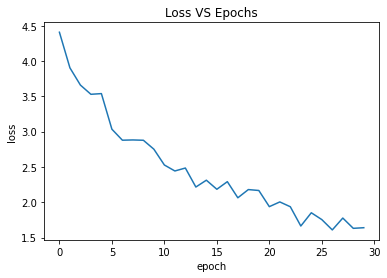

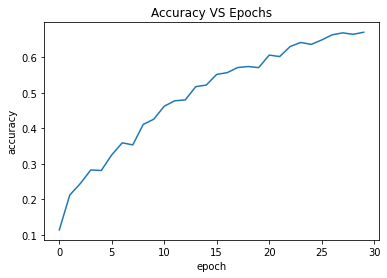

In [16]:
plt.plot(loss_hist)
plt.title('Loss VS Epochs')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

plt.plot(acc_hist)
plt.title('Accuracy VS Epochs')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

**Test**

In [17]:
best_net = best_net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
best_net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = best_net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 12/12 [00:12<00:00,  1.01s/it]

Test Accuracy: 0.6864846180435534
